# Solving non-linear coupled reaction-difusion problem

## Problem Description
$$ \frac{∂u}{∂t} = D_u \Delta u + k (a-u+u^2 v)  \tag{1} $$
$$ \frac{\partial v}{\partial t} = D_v \Delta v + k(b-u^2 v)  \tag{2}$$
$$ (x,y) \in \Omega, t \in (0, T]  \tag{3}$$
$$ u(x,y,0)=u_0(x,y), v(x,y,0) = v_0(x,y), (x,y) \in \Omega \tag{4} $$
$$ -D_u \nabla u \cdot n = 0, -D_v \nabla v \cdot n = 0, (x,y) \in \partial \Omega \tag{5}$$
$$ D_u = 0.05, D_v = 1.0, k = 5, a = 0.1305, b = 0.7695 \tag{6}$$
$$ u_0(x,y) = a+b+r(x,y), v_0(x,y) = \frac{b}{(a+b)^2} \tag{7}$$ 
$$ \Omega = (0,4) \times (0,4), T = 20 \tag{8} $$


Import packages and define global variables:

In [1]:
using LinearAlgebra
using Plots
using DifferentialEquations
using SparseArrays
using BenchmarkTools

Nx = Ny = 100           # number of integrals
Du, Dv = 0.05, 1.0      # difffusivity constants
k, a, b = 5, 0.1305, 0.7695 # reaction sonstants
FT = Float64;           #Float type
Lx = Ly = 4             # domain size
T = 20.0                # ending time
dx = FT(Lx)/FT(Nx) 
dy = FT(Ly)/FT(Ny)
h = dx = dy

0.04

In [2]:
function compute_u0() # equation (7)
    return a .+ b .+ 0.01 * (a + b) * rand((Nx - 1) * (Ny - 1))
end

function compute_v0()
    return fill(b / ((a + b)^2), (Nx - 1) * (Ny - 1))
end

# @btime u0 = compute_u0()
# @btime v0 = compute_v0()
# @code_warntype compute_u0()
# @code_warntype compute_v0()

  20.400 μs (12 allocations: 230.17 KiB)


  5.220 μs (6 allocations: 76.73 KiB)


9801-element Vector{Float64}:
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 ⋮
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002
 0.9500000000000002

In [3]:
function FDLaplacian2D()
    Dx = zeros(Nx, Nx-1)
    Dx[1:Nx+1:end] .= 1   # construct diagonals
    Dx[2:Nx+1:end] .= -1  
    Dx *= 1/dx  
    Dx[1, :] .= 0  # add boundary conditions
    Dx[end, :] .= 0


    Dy = zeros(Ny, Ny-1)
    Dy[1:Ny+1:end] .= 1     # construct diagonals
    Dy[2:Ny+1:end] .= 1
    Dy *= 1/dy
    Dy[1, :] .= 0   # add boundary conditions
    Dy[end, :] .= 0

    Lxx = transpose(Dx) * Dx
    Lyy = transpose(Dy) * Dy

    Ix = I(Nx-1)
    Iy = I(Ny-1)

    A = kron(Iy, Lxx) + kron(Lyy, Ix)
    return A
end

# @btime A = FDLaplacian2D()

# @code_warntype FDLaplacian2D()

  438.692 ms (60 allocations: 2.15 GiB)


9801×9801 Matrix{Float64}:
 1250.0  -625.0     0.0     0.0     0.0  …     0.0     0.0     0.0     0.0
 -625.0  1875.0  -625.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0  -625.0  1875.0  -625.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0  -625.0  1875.0  -625.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0  -625.0  1875.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0  -625.0  …     0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    ⋮                                    ⋱                             ⋮
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0
    0.0     0.0     0.0     0.0     0.0        0.0     0.0     0.0     0.0


  80.415 s (1765 allocations: 193.25 GiB)


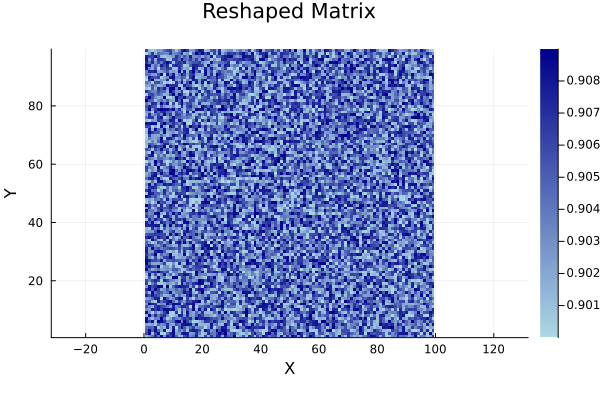

In [5]:
function RHS!(dx, x, p, t)
    du, dv = dx
    u, v = x
    c = u*u*v
    du = -Du * A * u .+ k * (a .- u .+ c)
    dv = -Dv * A * v .+ k * (b .- c)
end


tspan = (0.0, T)
u0 = compute_u0()
v0 = compute_v0()
A = FDLaplacian2D()
u = [u0; v0]
prob = ODEProblem(RHS!, u, tspan)

@code_warntype solve(prob, save_everystep = false)
@btime solve(prob, save_everystep = false)

sol = solve(prob, save_everystep = false)
uk, vk = sol.u
uArr = uk[1:(Nx-1)*(Ny-1)]
uArr = reshape(uArr, Nx-1, Ny-1)

heatmap(uArr, c=:blues, aspect_ratio=:equal, xlabel="X", ylabel="Y")